# Annotation Format Converter

Author: Jae Ro

## Task
Read in several `.seg` files (each corresponding with one image) and write a single `COCO JSON` file for that label file independent from other label files/images. 
- `.seg` -> `COCO JSON`

In particular, you will be writing code for
- Getting all the segmentation files programmatically (easy)
- Converting `.seg` files to COCO format (bulk of the challenge)
- Visualizing the images overlaid with segmentations and / or their bounding boxes
(important to demonstrate your code functionality)


Please develop your solution in a Juypyter notebook. Additionally, we ask that you
- Provide 10 randomly sampled example visualizations in your Jupyter Notebook
(Similar to the figure-1 below)
- Answer the following questions as the final step of the challenge in your Jupyter
Notebook
- Do you notice any areas that require improvement or changes if you had
additional time? If not, can you identify any potential enhancements or
modifications that could be implemented in the code?
- Attach 3 sample COCO JSON files that you converted from .seg format to your
email reply

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

from PIL import Image
import json
import os
from datetime import datetime
from typing import List, Dict, Tuple

In [2]:
segmentation_files = [
'./data/labels/gray/1132/86000.seg',
'./data/labels/gray/1132/118035.seg',
'./data/labels/color/1119/65132.seg'
]

dirpath_images = './data/images'
dirpath_labels = './data/labels'

# A. Exploratory Data Analysis

## 1. Understanding the `.seg` file format

```
## Seg file format is as follows:
    - format {*ascii|binary} {*cr|map}
    - date <date string>
    - image <int> -- image ID number
    - user <int> -- user ID number
    - width <int> --  width of image
    - height <int> - height of image
    - segments <int> --  number of segments
    - gray {*0|1} -- image presented in grayscale?
    - invert {*0|1} -- image presented with pixel values inverted?
    - flipflop {*0|1} -- image presented upside-down and backwards?
    - <data> -- denoting that the data is below
    - <s> <r> <c1> <c2> -- where <s> is the segment number; <r> is the row; <c1> and <c2> are column numbers.
```

In [3]:
example_seg_fpath = segmentation_files[0]

with open(example_seg_fpath) as f:
    for i, line in enumerate(f):
        if i ==14: break
        line = line.rstrip()
        vals = line.split(" ")
        print(vals)
        

['format', 'ascii', 'cr']
['date', 'Tue', 'Jul', '31', '12:30:00', '2001']
['image', '86000']
['user', '1132']
['width', '321']
['height', '481']
['segments', '14']
['gray', '1']
['invert', '0']
['flipflop', '0']
['data']
['0', '0', '0', '320']
['0', '1', '0', '320']
['0', '2', '0', '320']


### In the first line of data above the four number represent the following
- 0 -> segment 0
- 0 -> row 0
- 0 -> first column 0
- 320 -> second column 320

### Let's see if we can find all of the values for a single segment and get a better understanding of this format

In [4]:
seg_dict = {}
start = False
with open(example_seg_fpath) as f:
    for i, line in enumerate(f):
        line = line.rstrip()
        vals = line.split(" ")
        if len(vals) == 1 and vals[0] == 'data': 
            start=True
            continue
        if not start: continue
        
        # parse the segmentation annotation values
        seg_num = int(vals[0])
        row = int(vals[1])
        col_1, col_2 = int(vals[2]), int(vals[3])
        
        annot_dict = {'row': row, 'col_1': col_1, 'col_2': col_2 }
        seg_dict[seg_num] = seg_dict.get(seg_num, [])
        seg_dict[seg_num].append(annot_dict)

print(f"Length of seg_dict: {len(seg_dict)} is equal to the number of segments in header portion of file")
print(f"\nBelow is a sample of what we've stored so far for segment 0: \n\n {seg_dict[0][:5]}")

Length of seg_dict: 14 is equal to the number of segments in header portion of file

Below is a sample of what we've stored so far for segment 0: 

 [{'row': 0, 'col_1': 0, 'col_2': 320}, {'row': 1, 'col_1': 0, 'col_2': 320}, {'row': 2, 'col_1': 0, 'col_2': 320}, {'row': 3, 'col_1': 0, 'col_2': 320}, {'row': 4, 'col_1': 0, 'col_2': 320}]


### These look like they represent pixel coordinates so let's convert them to that format

In [5]:
seg_dict = {}
start = False
with open(example_seg_fpath) as f:
    for i, line in enumerate(f):
        line = line.rstrip()
        vals = line.split(" ")
        if len(vals) == 1 and vals[0] == 'data': 
            start=True
            continue
        if not start: continue
        
        # parse the segmentation annotation values
        seg_num = int(vals[0])
        row = int(vals[1])
        col_1, col_2 = int(vals[2]), int(vals[3])
        # ensuring order from left to right
        if col_1 > col_2: 
            col_1, col_2 = col_2, col_1
        # storing as list of 2 tuple points
        # coord_dict = [(row, col_1), (row, col_2)]
        seg_dict[seg_num] = seg_dict.get(seg_num, [])
        seg_dict[seg_num].append((row, col_1))
        seg_dict[seg_num].append((row, col_2))

print(f"\nBelow is a sample of our pixel coordinate converted format for segment 0: \n\n {seg_dict[0][:5]}\n")
print("Looks like we get 2 points per row for the annotation so we could have a bounding box or a more polygon shape")


Below is a sample of our pixel coordinate converted format for segment 0: 

 [(0, 0), (0, 320), (1, 0), (1, 320), (2, 0)]

Looks like we get 2 points per row for the annotation so we could have a bounding box or a more polygon shape


## 2. Understanding MS COCO JSON Format

```
# Basic structure
{
    "info": {...},
    "licenses": [...],
    "images": [...],
    "annotations": [...],
    "categories": [...], <-- Not in Captions annotations
    "segment_info": [...] <-- Only in Panoptic annotations
}

# Example 
"info": {
    "description": "COCO 2017 Dataset",
    "url": "http://cocodataset.org",
    "version": "1.0",
    "year": 2017,
    "contributor": "COCO Consortium",
    "date_created": "2017/09/01"
}
"images": [
    {
        "license": 4,
        "file_name": "000000397133.jpg",
        "coco_url": "http://images.cocodataset.org/val2017/000000397133.jpg",
        "height": 427,
        "width": 640,
        "date_captured": "2013-11-14 17:02:52",
        "flickr_url": "http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg",
        "id": 397133
    },
]
"annotations": [
    {
        "segmentation": [[510.66,423.01,511.72,420.03,...,510.45,423.01]],
        "area": 702.1057499999998,
        "iscrowd": 0,
        "image_id": 289343,
        "bbox": [473.07,395.93,38.65,28.67],
        "category_id": 18,
        "id": 1768
    },
    ...
]

"categories": [
    {
        "supercategory": "person",
        "id": 1,
        "name": "person"
    }
]


```

Note: Even though the annotation has multiple points representing the segmentation (likely not a box shape), there are still coordinates for the bounding box that encompases the farthest points in the segmentation mask

## 3. Visualizing an Image and Mask Pair

In [6]:
# small utility functions
def to_int(fields) -> int: 
    if len(fields) > 1: raise ValueError("error in converting to int. expected 1 value")
    return int(fields[0])

def to_bool(fields) -> bool:
    str_to_bool = {
        "1": True,
        "0": False
    }
    if len(fields) > 1: raise ValueError("error in converting to int. expected 1 value")
    if fields[0] not in str_to_bool: raise ValueError("Expected '1' or '0'")
    return str_to_bool[fields[0]]
    
def space_join_str(fields) -> str: 
    return " ".join(fields)

def parse_date_str(fields) -> dict: 
    date_str = space_join_str(fields)
    print(date_str)
    dt = datetime.strptime(date_str, '%a %b %d %H:%M:%S %Y')
    date = dt.strftime("%Y/%m/%d")
    time = dt.strftime("T%H:%M:%S+00:00")
    return { "date": date, "time": time }


# code to get metadata
header_keys = {
    "format": space_join_str,
    "date": parse_date_str,
    "image": to_int,
    "user": to_int,
    "width": to_int,
    "height": to_int,
    "segments": to_int,
    "gray": to_int,
    "invert": to_bool,
    "flipflop": to_bool
}

headers = {
    "format": None,
    "date": None,
    "image": None,
    "user": None,
    "width": None,
    "height": None,
    "segments": None,
    "gray": None,
    "invert": None,
    "flipflop": None
}

# storing annotation data
seg_dict = {}
start = False

# open and read example file
with open(example_seg_fpath) as f:
    for i, line in enumerate(f):
        line = line.rstrip()
        vals = line.split(" ")
        
        ## parsing header fields
        if vals[0] in headers and vals[0] in header_keys: 
            headers[vals[0]] =  header_keys[vals[0]](vals[1:])
            
        ## parsing out the annotation data
        if len(vals) == 1 and vals[0] == 'data': 
            start=True
            continue
        if not start: continue
        # parse the segmentation annotation values
        seg_num = int(vals[0])
        row = int(vals[1])
        col_1, col_2 = int(vals[2]), int(vals[3])
        # ensuring order from left to right
        if col_1 > col_2: col_1, col_2 = col_2, col_1
        # storing as list of 2 tuple points
        # coord_dict = [(row, col_1), (row, col_2)]
        seg_dict[seg_num] = seg_dict.get(seg_num, [])
        seg_dict[seg_num].append((row, col_1))
        seg_dict[seg_num].append((row, col_2))

print(headers)

Tue Jul 31 12:30:00 2001
{'format': 'ascii cr', 'date': {'date': '2001/07/31', 'time': 'T12:30:00+00:00'}, 'image': 86000, 'user': 1132, 'width': 321, 'height': 481, 'segments': 14, 'gray': 1, 'invert': False, 'flipflop': False}


### Raw Image

In [7]:
img_path = os.path.join(dirpath_images, f"{headers['image']}.jpg")
img_path

'./data/images/86000.jpg'

(481, 321, 3)


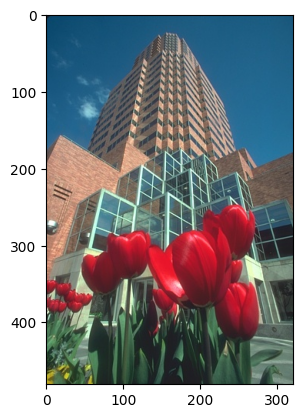

In [8]:
img = np.array(Image.open(img_path).convert('RGB'))
plt.imshow(img)

print(img.shape)

### Segmentation Mask - Rough

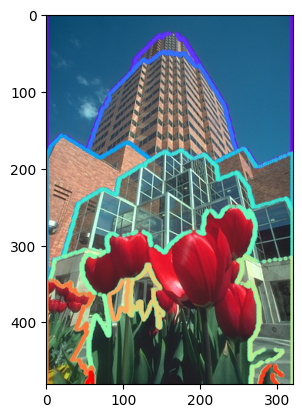

In [9]:
plt.imshow(img)
cs = cm.rainbow(np.linspace(0, 1, len(seg_dict)))
for i, seg_class in enumerate(seg_dict):
    seg_dict[seg_class] = sorted(seg_dict[seg_class], key=lambda x: (x[0], x[1]))
    list(zip(*seg_dict[seg_class]))
    x, y = zip(*[point for point in seg_dict[seg_class]])
    plt.plot(y, x, 'o', color=cs[i], markersize=2, alpha=0.5)

# B. Developing Core Functionality for SegFile
- Reading in Data
- Capturing necessary metadata required for correct pathfinding
- Visualizing Image and Segmentation Mask Overlays
- Converting metadata and annotation data into COCO JSON

In [10]:
### Small utility functions for data types and casting

def to_int(fields:List[str]) -> int:
    """Function to cast list to single int"""
    if len(fields) > 1: raise ValueError("error in converting to int. expected 1 value")
    return int(fields[0])

def to_bool(fields:List[str]) -> bool:
    """Function to cast list to single bool"""
    str_to_bool = {
        "1": True,
        "0": False
    }
    if len(fields) > 1: raise ValueError("error in converting to int. expected 1 value")
    if fields[0] not in str_to_bool: raise ValueError("Expected '1' or '0'")
    return str_to_bool[fields[0]]
    
def space_join_str(fields:List[str]) -> str: 
    """Function to cast list to single int"""

    return " ".join(fields)

def parse_date_str(fields:List[str]) -> datetime: 
    """Function to parse date and time from date string"""
    date_str = space_join_str(fields)
    dt = datetime.strptime(date_str, '%a %b %d %H:%M:%S %Y')
    return dt


### Utility Function for bounding box 
def calculate_bb_from_sorted_points(points:List[Tuple[int, int]]) -> List[int]:
    """Takes in list of point tuples and returns a single list in the format of
    [x1, y1, x2, y2] representing the corners of the top left and bottom right points
    of the bounding box area covered by all of the points in the list of points.
    
    Assumes points have been sorted in increasing order based on priorities of row, then column.
    
    Return [x1, y1, x2, y2]
    """
    min_x, min_y = 1e10, 1e10 
    max_x, max_y = 0, 0
    
    for p in points:
        min_x = min(min_x, p[1])
        min_y = min(min_y, p[0])
        
        max_x = max(max_x, p[1])
        max_y = max(max_y, p[0])
    
    return [min_x, min_y, max_x, max_y]


def calculate_area(bbox:List[int]) -> int:
    """calculates area of bounding box
    
    bbox: [x1,y1,x2,y2]
    
    where x1,y1 is top left
    and x2, y2 is bottom right
    
    returns single integer calculation of length x width calculation of area
    """
    x1,y1,x2,y2 = bbox
    if x2 < x1 or y2 < y1: raise ValueError(f"coordinates ordered incorrectly: {bbox}")
    area =  x2-x1 * y2-y1    
    return area    

### Utility Functions for visualizations

def load_image(img_path:str) -> Image:
    return Image.open(img_path).convert("RGB")

def load_image_as_np(img_path:str) -> np.ndarray:
    """loads image path as an numpy array
    """
    return np.array(load_image(img_path))
    

In [11]:

### Main Function to read and parse seg file
##Seg File Classes
class SegHeaders:
    def __init__(
        self, 
        format:str=None,
        date:str=None,
        image:int=None,
        user:str=None,
        width:int=None,
        height:int=None,
        segments:int=None,
        gray:int=None,
        invert:bool=False,
        flipflop:bool=False
    ) -> None:
        """
        """
        self.format = format
        self.date = date
        self.image = image
        self.user = user
        self.width = width
        self.height = height
        self.segments = segments
        self.gray = gray
        self.invert = invert
        self.flipflop = flipflop
        
    def to_dict(self):
        return {
            "format": self.format,
            "date": self.date,
            "image": self.image,
            "user": self.user,
            "width": self.width,
            "height": self.height,
            "segments": self.segments,
            "gray": self.gray,
            "invert": self.invert,
            "flipflop": self.flipflop
        }
    def __str__(self):
        return f"{self.to_dict()}"

class SegFileData:
    def __init__(self, headers:SegHeaders, data:dict) -> None:
        self.headers = headers
        self.data = data
        
    def get_bounding_box(self, seg_class:int) -> List[int]:
        """Function to get bounding box from list of sorted points
        """
        return calculate_bb_from_sorted_points(self.data[seg_class])
    

def read_seg_file(seg_fpath:str) -> SegFileData:
    """Function to take in a file path to .seg file and parse out headers and annotations
    as separate dictionaries.
    
    Returns tuple of two dictionaries: header_dict, data_dict
    """
    # header metadata
    header_keys = {
        "format": space_join_str,
        "date": parse_date_str,
        "image": to_int,
        "user": to_int,
        "width": to_int,
        "height": to_int,
        "segments": to_int,
        "gray": to_int,
        "invert": to_bool,
        "flipflop": to_bool
    }
    headers = {
        "format": None,
        "date": None,
        "image": None,
        "user": None,
        "width": None,
        "height": None,
        "segments": None,
        "gray": None,
        "invert": None,
        "flipflop": None
    }

    # storing annotation data
    seg_dict = {}
    start = False

    # open and read example file
    with open(seg_fpath) as f:
        for i, line in enumerate(f):
            line = line.rstrip()
            vals = line.split(" ")

            ## parsing header fields
            if vals[0] in headers and vals[0] in header_keys: 
                headers[vals[0]] =  header_keys[vals[0]](vals[1:])

            ## parsing out the annotation data
            if len(vals) == 1 and vals[0] == 'data': 
                start=True
                continue
            if not start: continue
            
            # parse the segmentation annotation values
            seg_num = int(vals[0])
            row = int(vals[1])
            col_1, col_2 = int(vals[2]), int(vals[3])
            
            # ensuring order from left to right
            if col_1 > col_2: col_1, col_2 = col_2, col_1
            
            # storing as list of 2 tuple points
            # coord_dict = [(row, col_1), (row, col_2)]
            seg_dict[seg_num] = seg_dict.get(seg_num, [])
            seg_dict[seg_num].append([row, col_1])
            seg_dict[seg_num].append([row, col_2])
                
    # sort points in segmentation dict based on priority of row, col
    for seg in seg_dict:
        points = seg_dict[seg]
        seg_dict[seg] = sorted(points, key=lambda x: (x[0], x[1]))
    
    return SegFileData(headers=SegHeaders(**headers), data=seg_dict)


In [12]:
sfd = read_seg_file(example_seg_fpath)
bb = sfd.get_bounding_box(0)

print(sfd.headers)
print(sfd.data[0][:10])

print(bb)

{'format': 'ascii cr', 'date': datetime.datetime(2001, 7, 31, 12, 30), 'image': 86000, 'user': 1132, 'width': 321, 'height': 481, 'segments': 14, 'gray': 1, 'invert': False, 'flipflop': False}
[[0, 0], [0, 320], [1, 0], [1, 320], [2, 0], [2, 320], [3, 0], [3, 320], [4, 0], [4, 320]]
[0, 0, 320, 197]


### Testing out Visualization with Bounding Box

[54, 47, 246, 191] 144 192


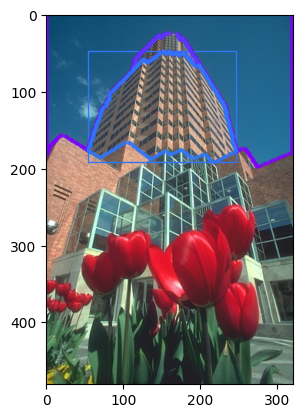

In [13]:

img_path = os.path.join(dirpath_images, f"{headers['image']}.jpg")
img = np.array(Image.open(img_path).convert('RGB'))


fig, ax = plt.subplots()
ax.imshow(img)

cs = cm.rainbow(np.linspace(0, 1, len(sfd.data)))
for i, seg_class in enumerate(sfd.data):
    y, x = zip(*[point for point in sfd.data[seg_class]])
    plt.plot(x, y, 'o', color=cs[i], markersize=2, alpha=0.5)
    if i == 2:
        bb = sfd.get_bounding_box(seg_class)
        h, w =  bb[3]-bb[1], bb[2]-bb[0]
        print(bb, h, w)
        rect = patches.Rectangle((bb[0], bb[1]), w, h, linewidth=1, edgecolor=cs[i], facecolor='none')
        ax.add_patch(rect)        
        break

plt.show()

# C. Converting Seg File to MS COCO JSON

In [14]:
### Main function to convert SegFileData to MS COCO JSON Format
## MSCOCO File Format Class
        
class COCO:
    def __init__(
        self, 
        info:dict={}, 
        licenses:List[dict]=[],
        images:List[dict]=[],
        annotations:List[dict]=[],
        categories:List[dict]=[],
        segment_info:List[dict]=[]
    ) -> None:
        """Init function for MS COCO JSON
        
        Basic Structure
        {
            "info": {...},
            "licenses": [...],
            "images": [...],
            "annotations": [...],
            "categories": [...], <-- Not in Captions annotations
            "segment_info": [...] <-- Only in Panoptic annotations
        }
        """
        self.info = info
        self.licenses = licenses
        self.images = images
        self.annotations = annotations
        self.categories = categories
        self.segment_info = segment_info
    
    def to_dict(self):
        return {
            "info": self.info,
            "licenses": self.licenses,
            "images": self.images,
            "annotations": self.annotations,
            "categories": self.categories,
            "segment_info": self.segment_info
        }
    def __repr__(self):
        return f"COCO({self.to_dict()})"
    
    def set_info(self, info:dict): 
        self.info = info
    
    def set_licenses(self, licenses:List[dict]): 
        self.licenses = licenses
    
    def set_images(self, images): 
        self.images = images
    
    def set_annotations(self, annotations:List[dict]): 
        self.annotations = annotations
    
    def set_categories(self, categories:List[dict]):
        self.categories = categories
    
    def set_segment_info(self, segment_info:List[dict]): 
        self.segment_info = segment_info
        
    def add_category(self, category_dict:dict):
        self.categories.append(category_dict)
    
    def add_annotation(self, annotation:dict):
        self.annotations.append(annotation)
    
        
def convert_sfd_to_coco(sfd:SegFileData) -> COCO:
    """Function to take in an instance of SegFileData
    convert it to the necessary format required of MS COCO JSON
    
    Return an instance of COCO
    """
    coco = COCO()
    
    # default values
    year, date_created, date_captured = None, None, None
    super_category = "Human"

    # parse out date information for coco format
    if sfd.headers.date and isinstance(sfd.headers.date, datetime):
        year = sfd.headers.date.year
        date_created = sfd.headers.date.strftime("$Y-%m-T%H:%M:%S+00:00")
        date_captured = date_created
    
    
    # set coco info
    coco.set_info({
        "description": "Seg2Coco Example",
        "url": "N/A",
        "version": "0.1.0",
        "year": year,
        "contributor": "Jae Ro",
        "date_created": date_created
    })
    
    # set images
    coco.set_images([
        {
            "id": sfd.headers.image,
            "license": 1,
            "file_name": f"{sfd.headers.image}.jpg",
            "height": sfd.headers.height,
            "width": sfd.headers.width,
            "date_captured": date_captured
        }
    ])
    annotations = []
    # parse annotation data
    for i, segment in enumerate(sfd.data):
        # parse category data
        cat_id, category_name = i,  f"category-{i}"
        coco.add_category({
            "id": cat_id,
            "name": category_name,
            "supercategory": super_category
        })
        # parse annotation data
        bbox = sfd.get_bounding_box(segment)
        annotations.append({
            "id": segment,
            "image_id": sfd.headers.image,
            "category_id": cat_id, 
            "bbox": bbox,
            "area": calculate_area(bbox),
            "segmentation": sfd.data[segment],
            "iscrowd": 0
        })
    
    coco.set_annotations(annotations)
   
    return coco


In [15]:
coco = convert_sfd_to_coco(sfd)
print(coco.info)
print(coco.images)
print(coco.categories)
print(len(coco.annotations))

{'description': 'Seg2Coco Example', 'url': 'N/A', 'version': '0.1.0', 'year': 2001, 'contributor': 'Jae Ro', 'date_created': '$Y-07-T12:30:00+00:00'}
[{'id': 86000, 'license': 1, 'file_name': '86000.jpg', 'height': 481, 'width': 321, 'date_captured': '$Y-07-T12:30:00+00:00'}]
[{'id': 0, 'name': 'category-0', 'supercategory': 'Human'}, {'id': 1, 'name': 'category-1', 'supercategory': 'Human'}, {'id': 2, 'name': 'category-2', 'supercategory': 'Human'}, {'id': 3, 'name': 'category-3', 'supercategory': 'Human'}, {'id': 4, 'name': 'category-4', 'supercategory': 'Human'}, {'id': 5, 'name': 'category-5', 'supercategory': 'Human'}, {'id': 6, 'name': 'category-6', 'supercategory': 'Human'}, {'id': 7, 'name': 'category-7', 'supercategory': 'Human'}, {'id': 8, 'name': 'category-8', 'supercategory': 'Human'}, {'id': 9, 'name': 'category-9', 'supercategory': 'Human'}, {'id': 10, 'name': 'category-10', 'supercategory': 'Human'}, {'id': 11, 'name': 'category-11', 'supercategory': 'Human'}, {'id': 12,

### Saving COCO as JSON

In [16]:
with open('sample_output.json', 'w') as fh:
    json.dump(coco.to_dict(), fh)

# D. END RESULT API FUNCTIONS!

In [17]:
def convert_to_coco(segmentation_files:List[str], dirpath_images:str) -> List[str]:
    """Function to convert a list of segmentation_files into coco json writeable dictionaries,
    write them to disk, and then return list of filepaths
    
    returns list of file paths to MS COCO JSON formatted files
    """
    coco_paths = []
    for seg_fpath in segmentation_files:
        # read in seg file as SegFileData
        sfd = read_seg_file(seg_fpath)
        # convert SegFileData to COCO
        cc = convert_sfd_to_coco(sfd)
        
        # parse path to save COCO as JSON
        path_arr = seg_fpath.split("/")
        base_path, end_file = path_arr[:-1], path_arr[-1].split(".seg")[0]
        coco_fpath = os.path.join("/".join(base_path), end_file)
        
        # try saving as JSON
        try:
            with open(f"{coco_fpath}.json", "w") as fh:
                json.dump(cc.to_dict(), fh)
            
            # if successful - add to coco_paths to return
            coco_paths.append(f"{coco_fpath}.json")

        except Exception as e:
            print(e)
        
    return coco_paths


def visualize(coco_file:str, dirpath_images:str='./data/images'):
    """Function to visualize image and segmentation mask pair as an overlay
    """
    with open(coco_file, 'r') as f:
        data = json.load(f)
    
    coco = COCO(
        info=data['info'],
        licenses=data['licenses'],
        images=data['images'],
        annotations=data['annotations'],
        categories=data['categories'],
        segment_info=data['segment_info']
    )
    
    img_path = os.path.join(dirpath_images, coco.images[0]['file_name'])
    img = load_image_as_np(img_path)
    
    fig, ax = plt.subplots()
    ax.imshow(img)

    cs = cm.rainbow(np.linspace(0, 1, len(coco.annotations)))
    for i, annot in enumerate(coco.annotations): 
        bb = annot['bbox']
        segment = annot['segmentation']
        y, x = zip(*[point for point in segment])
        plt.plot(x, y, 'o', color=cs[i], markersize=2, alpha=0.5)
        h, w =  bb[3]-bb[1], bb[2]-bb[0]
        rect = patches.Rectangle((bb[0], bb[1]), w, h, linewidth=2, edgecolor=cs[i], facecolor=cs[i], alpha=0.3)
        ax.add_patch(rect)        

    plt.show()
    


# E. API Usage Test

./data/labels/gray/1132/86000.json


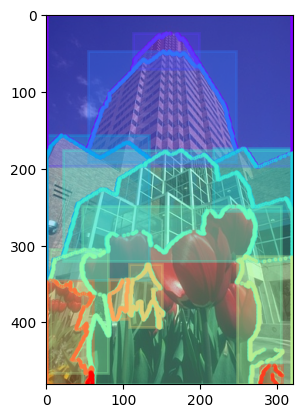

In [18]:
# list of all of the individual segmentation files - You should get this programmatically
segmentation_files = [
'./data/labels/gray/1132/86000.seg',
'./data/labels/gray/1132/118035.seg',
'./data/labels/color/1119/65132.seg'
]

dirpath_images = './data/images'

coco_files = convert_to_coco(segmentation_files, dirpath_images)
coco_file = np.random.choice(coco_files, 1)[0]

print(coco_file)

# Should visualize the randomly selected image and its segmentation as overlays
visualize(coco_file)